In [91]:
import pandas as pd
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import minmax_scale
from scipy.spatial.distance import pdist,squareform

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

import pprint as pp

### Table of Contents
* [Distribucion de los datos](#distribucion)
* [Clustering](#clustering)
    * [Evaluacion del clustering](#eval_clustering)
    * [Entrenamiento del modelo](#clustering_entrenamiento)
* [Preprocesamiento charts](#charts)
* [Modelos de clasificacion](#clasificacion)
    * [Pipelines](#pipelines)

In [92]:
data = pd.read_csv("data/consolidated/spot-track-data/consolidated_track_data.csv")
features = pd.read_csv("data/consolidated/spot-track-audio-features/consolidated_audio_features.csv")
charts = pd.read_csv("data/consolidated/spotify-charts-weekly-top-charts/consolidated_weekly_charts.csv")

In [93]:
print ("Data")
display(data.columns)
print ("\nFeatures")
display(features.columns)
print ("\nCharts")
display(charts.columns)

Data


Index(['track_id', 'track_name', 'type', 'popularity', 'duration_ms',
       'is_explicit', 'is_local', 'artist_id', 'artist_name', 'artist_type',
       'feat_artists_id', 'feat_artists_name', 'album_id', 'album_name',
       'album_type', 'album_release_date', 'album_total_tracks'],
      dtype='object')


Features


Index(['track_id', 'duration_ms', 'time_signature', 'tempo', 'key', 'mode',
       'valence', 'liveness', 'instrumentalness', 'acousticness',
       'speechiness', 'loudness', 'energy', 'danceability'],
      dtype='object')


Charts


Index(['region', 'week', 'date_from', 'date_to', 'track_id', 'track_name',
       'artist', 'track_position', 'track_streams', 'track_url'],
      dtype='object')

In [94]:
features.iloc[0]

track_id            5aAx2yezTd8zXrkmtKl66Z
duration_ms                         230453
time_signature                           4
tempo                              186.054
key                                      7
mode                                     1
valence                              0.535
liveness                             0.134
instrumentalness                  3.49e-06
acousticness                         0.165
speechiness                          0.282
loudness                            -7.028
energy                               0.594
danceability                         0.681
Name: 0, dtype: object

### Distribución de los datos <a class="anchor" id="distribucion"></a>

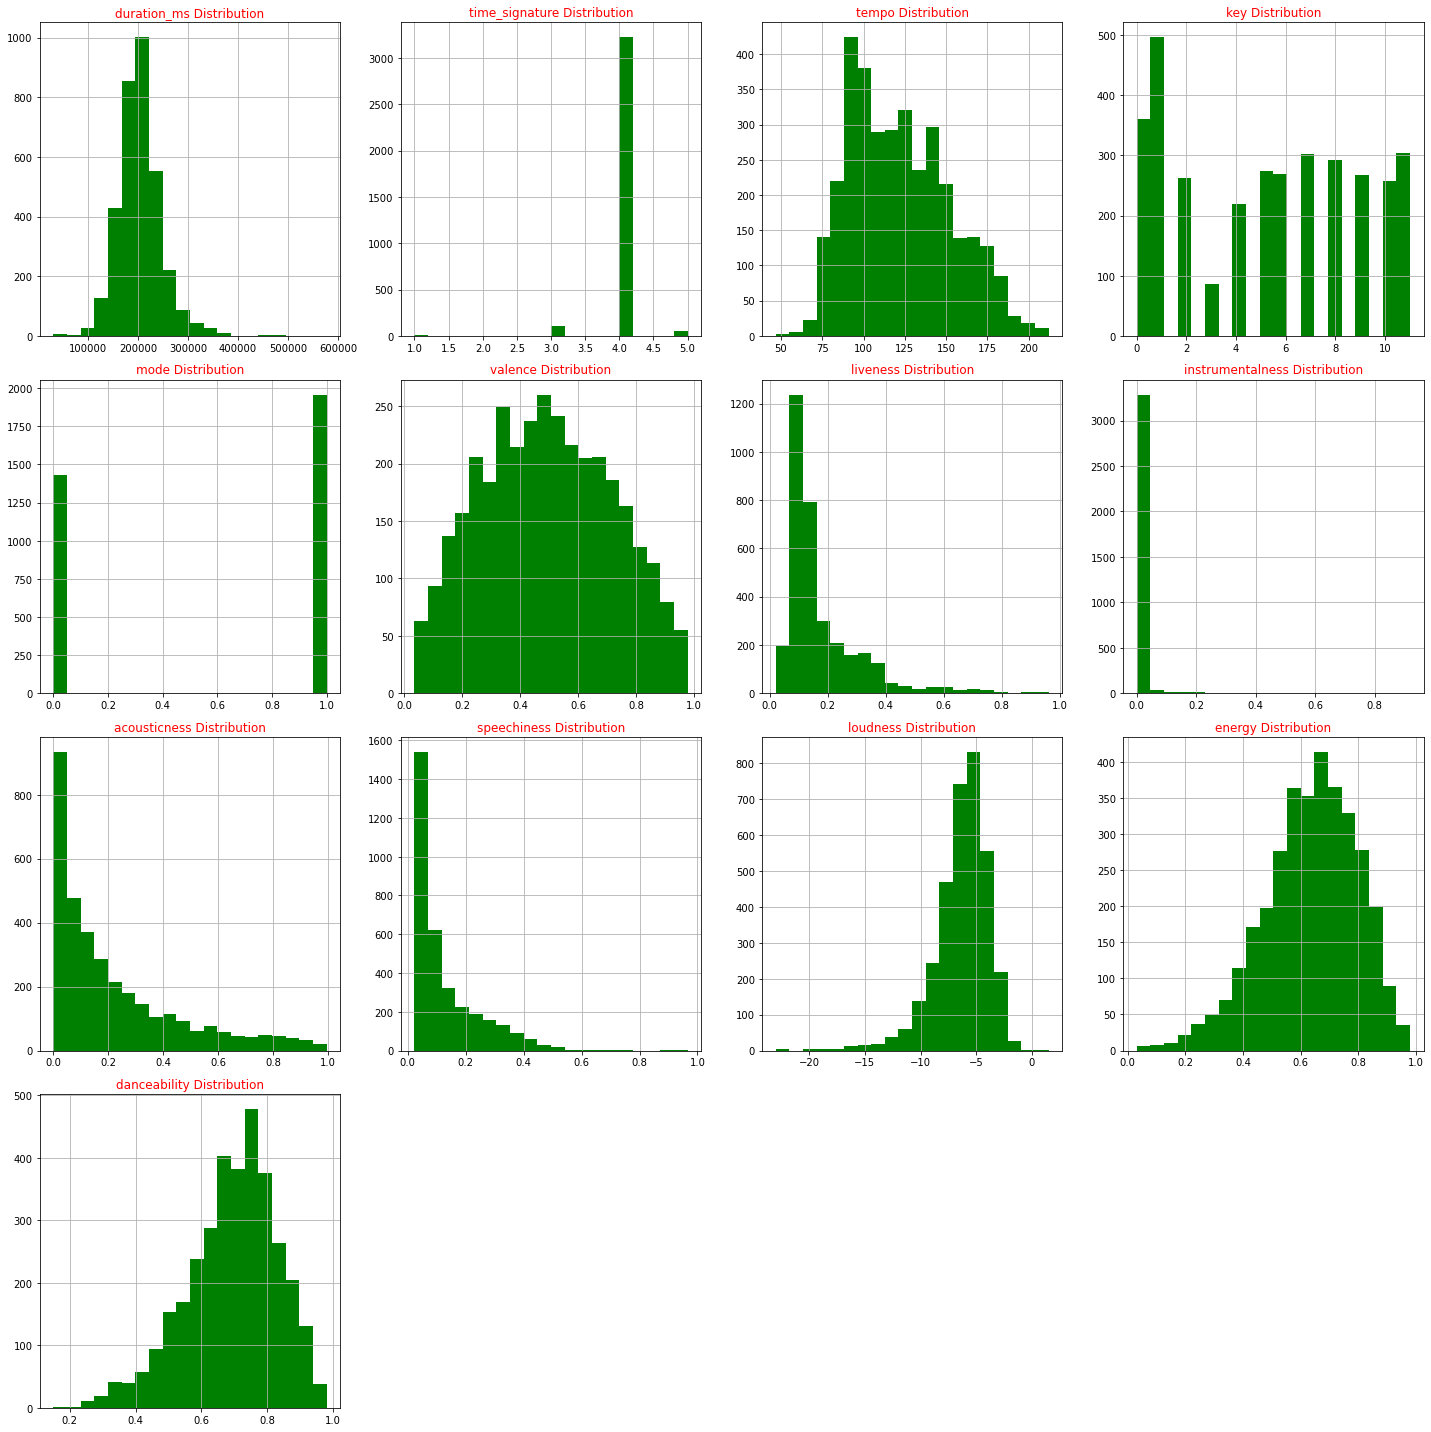

In [95]:
columnas = features[['duration_ms', 'time_signature', 'tempo', 'key', 'mode',
               'valence', 'liveness', 'instrumentalness', 'acousticness',
               'speechiness', 'loudness', 'energy', 'danceability']]

fig=plt.figure(figsize=(20,20))
for i, feature in enumerate(columnas):
    ax=fig.add_subplot(4,4,i+1)
    columnas[feature].hist(bins=20,ax=ax,facecolor='green')
    ax.set_title(feature+" Distribution",color='red')

fig.tight_layout()  
plt.show()

### Clustering <a class="anchor" id="clustering"></a>

In [96]:
features = pd.get_dummies(features, columns=["key", "mode", "time_signature"])

In [97]:
X=features[['tempo', 'valence', 'liveness', 'instrumentalness', 'acousticness',
                          'speechiness', 'loudness', 'energy', 'danceability']]

scaler=StandardScaler()
X_scaled = scaler.fit_transform(X)

inertia=[]
sil=[]
ch_scores=[]
k_values=range(2,20,2)

for k in k_values:
    print(k)
    km=KMeans(n_clusters=k)
    km.fit(X_scaled)
    inertia.append(km.inertia_)    

2
4
6
8
10
12
14
16
18


Text(0, 0.5, 'Inertia')

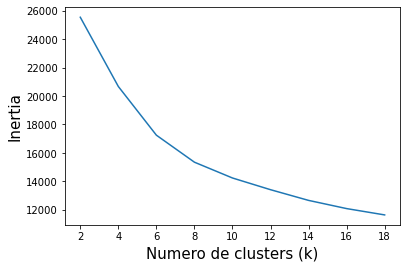

In [98]:
plt.plot(k_values,inertia);
# plt.vlines(4,np.min(inertia),np.max(inertia),linestyle='dashed');
plt.xlabel('Numero de clusters (k)',fontsize=15);plt.ylabel('Inertia',fontsize='15')

### Heatmap estandarizado de las features

<AxesSubplot:>

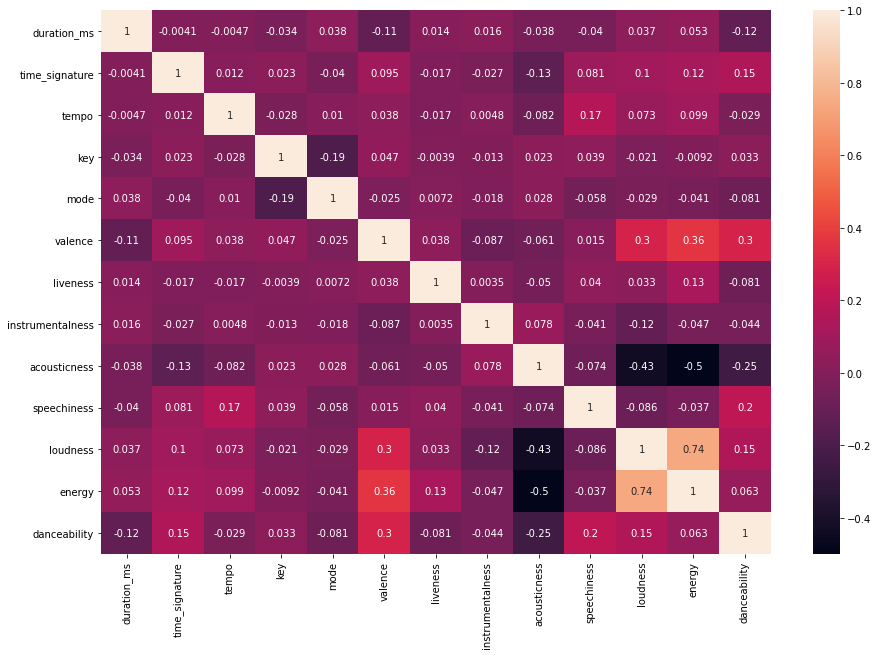

In [99]:
scaler=StandardScaler()
plt.figure(figsize=(15, 10))
scaled_features=scaler.fit_transform(columnas)
sns.heatmap(columnas.corr(), annot=True)
# sns.heatmap(squareform(pdist(scaled_features)),cmap='Blues')
# plt.xticks(np.arange(1,len(Nombre)+1)-0.5,Nombre);
# plt.yticks(np.arange(1,len(Nombre)+1)-0.5,Nombre,rotation=45);

### Preprocesamiento<a class="anchor" id="charts"></a>


In [100]:
charts = pd.read_csv("data/consolidated/spotify-charts-weekly-top-charts/consolidated_weekly_charts.csv")
charts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21200 entries, 0 to 21199
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   region          21200 non-null  object
 1   week            21200 non-null  object
 2   date_from       21200 non-null  object
 3   date_to         21200 non-null  object
 4   track_id        21200 non-null  object
 5   track_name      21200 non-null  object
 6   artist          21200 non-null  object
 7   track_position  21200 non-null  int64 
 8   track_streams   21200 non-null  int64 
 9   track_url       21200 non-null  object
dtypes: int64(2), object(8)
memory usage: 1.6+ MB


In [101]:
charts['date_from'] = pd.to_datetime(charts['date_from'])
charts['date_to'] = pd.to_datetime(charts['date_to'])
charts["tiempo_top"] = charts.date_to - charts.date_from


charts["concat"] = charts["track_id"] + "_" + charts["track_position"].astype(str)


top_por_track = pd.DataFrame(charts.groupby(by="track_id")["track_position"].min())
top_por_track["concat"] = top_por_track.index + "_" + top_por_track["track_position"].astype(str)

juntos = pd.merge(left=charts, right=top_por_track, how="inner", on="concat" )

juntos

,region,week,date_from,date_to,track_id,track_name,artist,track_position_x,track_streams,track_url,tiempo_top,concat,track_position_y
0,global,2016-12-23--2016-12-30,2016-12-23,2016-12-30,5aAx2yezTd8zXrkmtKl66Z,Starboy,The Weeknd,1,25286465,https://open.spotify.com/track/5aAx2yezTd8zXrk...,7 days,5aAx2yezTd8zXrkmtKl66Z_1,1
1,global,2016-12-23--2016-12-30,2016-12-23,2016-12-30,7BKLCZ1jbUBVqRi2FVlTVw,Closer,The Chainsmokers,2,22047697,https://open.spotify.com/track/7BKLCZ1jbUBVqRi...,7 days,7BKLCZ1jbUBVqRi2FVlTVw_2,2
2,global,2016-12-23--2016-12-30,2016-12-23,2016-12-30,5knuzwU65gJK7IF5yJsuaW,Rockabye (feat. Sean Paul & Anne-Marie),Clean Bandit,3,19794482,https://open.spotify.com/track/5knuzwU65gJK7IF...,7 days,5knuzwU65gJK7IF5yJsuaW_3,3
3,global,2016-12-23--2016-12-30,2016-12-23,2016-12-30,4pdPtRcBmOSQDlJ3Fk945m,Let Me Love You,DJ Snake,4,17965723,https://open.spotify.com/track/4pdPtRcBmOSQDlJ...,7 days,4pdPtRcBmOSQDlJ3Fk945m_4,4
4,global,2016-12-23--2016-12-30,2016-12-23,2016-12-30,5MFzQMkrl1FOOng9tq6R9r,Don't Wanna Know,Maroon 5,5,16966668,https://open.spotify.com/track/5MFzQMkrl1FOOng...,7 days,5MFzQMkrl1FOOng9tq6R9r_5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3622,global,2021-01-15--2021-01-22,2021-01-15,2021-01-22,1f3yAtsJtY87CTmM8RLnxf,Smells Like Teen Spirit,Nirvana,178,5118391,https://open.spotify.com/track/1f3yAtsJtY87CTm...,7 days,1f3yAtsJtY87CTmM8RLnxf_178,178
3623,global,2021-01-15--2021-01-22,2021-01-15,2021-01-22,4PEfJZpVjdclfzZ9XO8uDw,Hasta Abajo,Kevin Roldan,184,4994621,https://open.spotify.com/track/4PEfJZpVjdclfzZ...,7 days,4PEfJZpVjdclfzZ9XO8uDw_184,184
3624,global,2021-01-15--2021-01-22,2021-01-15,2021-01-22,5ri4zqtWhG07hIuNNDWP76,Fly Away,Tones And I,189,4950096,https://open.spotify.com/track/5ri4zqtWhG07hIu...,7 days,5ri4zqtWhG07hIuNNDWP76_189,189
3625,global,2021-01-15--2021-01-22,2021-01-15,2021-01-22,78xj07VVFK5uHTaGPIu13S,Buss It,Erica Banks,191,4915403,https://open.spotify.com/track/78xj07VVFK5uHTa...,7 days,78xj07VVFK5uHTaGPIu13S_191,191


In [102]:
juntos.sort_values(by="date_to", ascending=False, inplace=True)
juntos.drop_duplicates("track_id", inplace=True)
juntos["track_id"].value_counts()

5BRUlCrkTljRTux8BUPUDp    1
6WkJ2OK163XXS2oARUC9JM    1
7KZ5MMVgBVox9ycroB2UrI    1
42lqBjPYlmL1EXpMDXvhSN    1
7vAXN57IQ0sj049wZGIboE    1
                         ..
0jdny0dhgjUwoIp5GkqEaA    1
5aXgz1oKK8Q9z9xvTmSnrO    1
1x4MJYA9mJRph3fygU51K4    1
2lCkncy6bIB0LTMT7kvrD1    1
2H1liABu20HXBOmbt5SQz1    1
Name: track_id, Length: 3391, dtype: int64

In [103]:
def posicion(x):
    if 1 <= x <= 10:
        return "top 10"
    if 11 <= x <= 25:
        return "top 25"
    if 26 <= x <= 50:
        return "top 50"
    if  51 <= x <= 100:
        return "top 100"
    if 101 <= x <= 200:
        return "top 200"
    
    
juntos["label"] = juntos["track_position_x"].apply(lambda x: posicion(int(x)))
# juntos_dummies = pd.get_dummies(juntos, columns=["label"])
juntos.head()
#juntos_dummies.columns

,region,week,date_from,date_to,track_id,track_name,artist,track_position_x,track_streams,track_url,tiempo_top,concat,track_position_y,label
3626,global,2021-01-15--2021-01-22,2021-01-15,2021-01-22,4aarlAfLKVCTxUDNgbwhjH,Cry Baby (feat. DaBaby),Megan Thee Stallion,192,4910910,https://open.spotify.com/track/4aarlAfLKVCTxUD...,7 days,4aarlAfLKVCTxUDNgbwhjH_192,192,top 200
3603,global,2021-01-15--2021-01-22,2021-01-15,2021-01-22,1FP9s72rDYty6mfoOEYKnE,All We Got (feat. KIDDO),Robin Schulz,92,7245986,https://open.spotify.com/track/1FP9s72rDYty6mf...,7 days,1FP9s72rDYty6mfoOEYKnE_92,92,top 100
3601,global,2021-01-15--2021-01-22,2021-01-15,2021-01-22,02MWAaffLxlfxAUY7c5dvx,Heat Waves,Glass Animals,82,7518807,https://open.spotify.com/track/02MWAaffLxlfxAU...,7 days,02MWAaffLxlfxAUY7c5dvx_82,82,top 100
3600,global,2021-01-15--2021-01-22,2021-01-15,2021-01-22,2tI4WyzqOOwC23S5m0kqcB,At My Worst,Pink Sweat$,80,7649332,https://open.spotify.com/track/2tI4WyzqOOwC23S...,7 days,2tI4WyzqOOwC23S5m0kqcB_80,80,top 100
3599,global,2021-01-15--2021-01-22,2021-01-15,2021-01-22,0HC6S4VpCGAZvyxTdrMRIQ,De Una Vez,Selena Gomez,66,8196086,https://open.spotify.com/track/0HC6S4VpCGAZvyx...,7 days,0HC6S4VpCGAZvyxTdrMRIQ_66,66,top 100


In [104]:
juntos_dummies = juntos.drop(columns=["region", 'week', 'track_position_x', 'track_url', "tiempo_top"])

In [105]:
df = pd.merge(left=juntos_dummies, right=features, how="inner", on="track_id")
df

,date_from,date_to,track_id,track_name,artist,track_streams,concat,track_position_y,label,duration_ms,...,key_8,key_9,key_10,key_11,mode_0,mode_1,time_signature_1,time_signature_3,time_signature_4,time_signature_5
0,2021-01-15,2021-01-22,4aarlAfLKVCTxUDNgbwhjH,Cry Baby (feat. DaBaby),Megan Thee Stallion,4910910,4aarlAfLKVCTxUDNgbwhjH_192,192,top 200,137984,...,0,0,0,1,0,1,0,0,1,0
1,2021-01-15,2021-01-22,1FP9s72rDYty6mfoOEYKnE,All We Got (feat. KIDDO),Robin Schulz,7245986,1FP9s72rDYty6mfoOEYKnE_92,92,top 100,190218,...,0,0,0,0,0,1,0,0,1,0
2,2021-01-15,2021-01-22,02MWAaffLxlfxAUY7c5dvx,Heat Waves,Glass Animals,7518807,02MWAaffLxlfxAUY7c5dvx_82,82,top 100,238805,...,0,0,0,1,0,1,0,0,1,0
3,2021-01-15,2021-01-22,2tI4WyzqOOwC23S5m0kqcB,At My Worst,Pink Sweat$,7649332,2tI4WyzqOOwC23S5m0kqcB_80,80,top 100,170345,...,0,0,0,0,0,1,0,0,1,0
4,2021-01-15,2021-01-22,0HC6S4VpCGAZvyxTdrMRIQ,De Una Vez,Selena Gomez,8196086,0HC6S4VpCGAZvyxTdrMRIQ_66,66,top 100,155956,...,0,0,0,1,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3386,2016-12-23,2016-12-30,0sXvAOmXgjR2QUqLK1MltU,La Bicicleta,Carlos Vives,4896546,0sXvAOmXgjR2QUqLK1MltU_85,85,top 100,227707,...,0,0,0,0,0,1,0,0,1,0
3387,2016-12-23,2016-12-30,2HzfRSfCogBSsgW2CckVA2,Lot to Learn,Luke Christopher,4833942,2HzfRSfCogBSsgW2CckVA2_89,89,top 100,248387,...,0,0,0,0,0,1,0,0,1,0
3388,2016-12-23,2016-12-30,5J1c3M4EldCfNxXwrwt8mT,Traicionera,Sebastian Yatra,4805621,5J1c3M4EldCfNxXwrwt8mT_91,91,top 100,228467,...,0,0,0,1,0,1,0,0,1,0
3389,2016-12-23,2016-12-30,1Tt4sE4pXi57mTD1GCzsqm,Needed Me,Rihanna,4583611,1Tt4sE4pXi57mTD1GCzsqm_96,96,top 100,191600,...,0,0,0,0,1,0,0,0,1,0


In [245]:
df['artist'].value_counts()

Drake              84
Ariana Grande      61
Taylor Swift       61
Juice WRLD         53
Post Malone        53
                   ..
FRENSHIP            1
Alexander 23        1
Leslie Grace        1
Michael Jackson     1
True Damage         1
Name: artist, Length: 731, dtype: int64

In [106]:
data_final = pd.read_csv('data/consolidated/df_final.csv')

In [107]:
data_final.columns

Index(['Unnamed: 0', 'track_id', 'track_name', 'artist', 'artist_id',
       'artists_collab_id', 'track_streams', 'date_from', 'date_to',
       'peak_date', 'track_position', 'streams', 'duration_ms',
       'time_signature', 'tempo', 'key', 'mode', 'valence', 'liveness',
       'instrumentalness', 'acousticness', 'speechiness', 'loudness', 'energy',
       'danceability', 'label_top 10', 'label_top 25', 'label_top 50',
       'label_top 100', 'label_top 200'],
      dtype='object')

In [108]:
data_final_label = pd.merge(data_final, juntos[['track_id','label']], on='track_id')
# data_final_label

In [109]:
data_final_label.shape

(3391, 31)

In [110]:
data_x = data_final_label.drop(columns = ['label_top 10','label_top 25','label_top 50','label_top 100',
                                          'label_top 200','Unnamed: 0','track_id','track_name','artist_id',
                                          'artists_collab_id','artist','track_streams','date_from', 'date_to', 
                                          'peak_date', 'track_position','duration_ms', 'key', 'mode','label'])
data_x.columns
data_x['streams'].fillna(value=0,inplace=True)
data_x = pd.get_dummies(data_x, columns=["time_signature"])
data_x.columns

Index(['streams', 'tempo', 'valence', 'liveness', 'instrumentalness',
       'acousticness', 'speechiness', 'loudness', 'energy', 'danceability',
       'time_signature_1', 'time_signature_3', 'time_signature_4',
       'time_signature_5'],
      dtype='object')

In [111]:
data_y = data_final_label['label']
data_y.value_counts()

top 200    1401
top 100     852
top 50      477
top 25      361
top 10      300
Name: label, dtype: int64

In [112]:
features_basura = ['Unnamed: 0','track_id','track_name','artist_id','artists_collab_id','artist','track_streams','date_from', 'date_to', 'peak_date', 'track_position','duration_ms', 'key', 'mode']

In [113]:
scaler = StandardScaler()
data_x_scaled = scaler.fit_transform(data_x)
train_x, val_x, train_y, val_y = train_test_split(data_x_scaled, data_y, test_size=0.2, random_state=42)

#### Distribución de los datos por label

In [230]:
import seaborn as sns
dist_plot_df = data_final_label.copy().drop(columns=['label_top 10','label_top 25','label_top 50','label_top 100', 'label_top 200', 
                                                     'Unnamed: 0','track_id','track_name','artist_id', 'artists_collab_id', 'artist', 
                                                     'track_streams','date_from', 'date_to', 'peak_date', 'track_position','duration_ms', 'key', 'mode'])
scaler = StandardScaler()

# dist_plot_df_std['streams'].fillna(value=0, inplace=True)
dist_plot_df_std = scaler.fit_transform(dist_plot_df.drop(columns=['label']))
dist_plot_df_std = pd.DataFrame(dist_plot_df_std, columns=dist_plot_df.drop(columns=['label']).columns)
dist_plot_df_std['streams'].fillna(value=0, inplace=True)
dist_plot_df_std = dist_plot_df_std.join(dist_plot_df['label'])
dist_plot_df_std.head()

,streams,time_signature,tempo,valence,liveness,instrumentalness,acousticness,speechiness,loudness,energy,danceability,label
0,-0.555341,0.093779,0.263119,0.553915,0.315968,-0.147649,-0.931920,1.989211,-0.645267,-1.213362,1.911025,top 200
1,-0.602430,0.093779,1.124320,1.936746,-0.388824,-0.147649,-0.136587,1.902866,-0.090202,-0.608386,0.829338,top 100
2,-0.616556,0.093779,-0.402316,1.354972,0.458426,-0.147649,-0.696783,0.728585,0.123190,-0.812102,1.903813,top 200
3,-0.555811,0.093779,0.094894,0.048220,0.300973,-0.147649,-0.025994,-0.519090,0.036449,-0.744197,0.822127,top 200
4,0.000000,0.093779,-0.008363,1.260994,1.463130,-0.147649,0.050571,0.037831,0.062919,0.181787,1.024041,top 200


In [210]:
# Order for labels.
col_order=['top 10', 'top 25', 'top 50', 'top 100', 'top 200']
# Create an array with the colors you want to use
colors = ["#1DB954", "#4374B3"]
# Set your custom color palette
palette = sns.set_palette(sns.color_palette(colors))

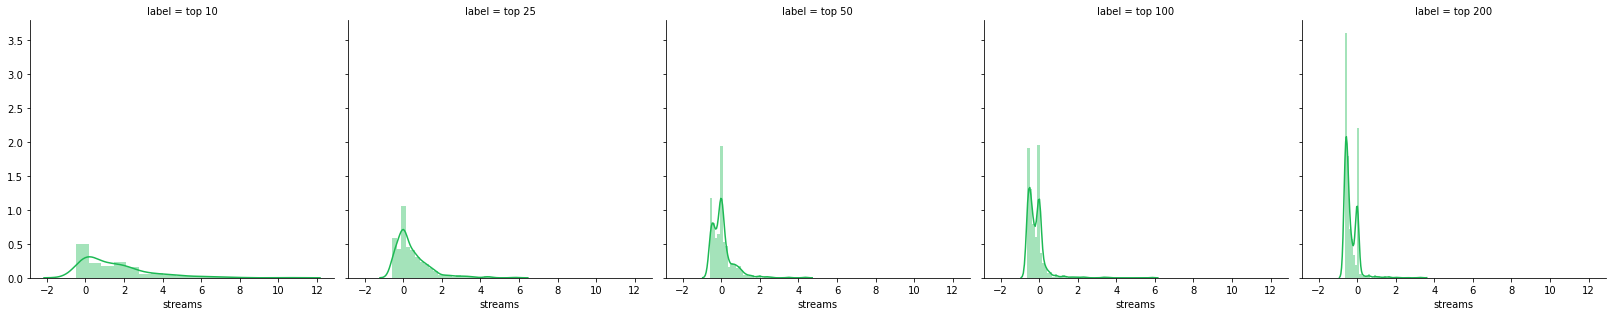

In [231]:
g = sns.FacetGrid(dist_plot_df_std, col="label", height=4.5, aspect=1, col_order=col_order, palette=palette)
g.map(sns.distplot, "streams")

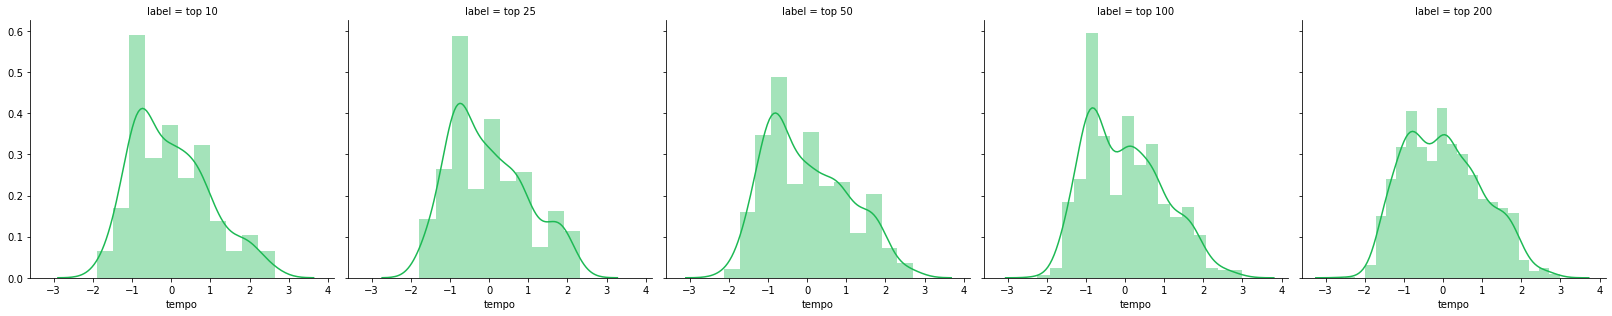

In [232]:
g = sns.FacetGrid(dist_plot_df_std, col="label", height=4.5, aspect=1, col_order=col_order, palette=palette)
g.map(sns.distplot, "tempo")

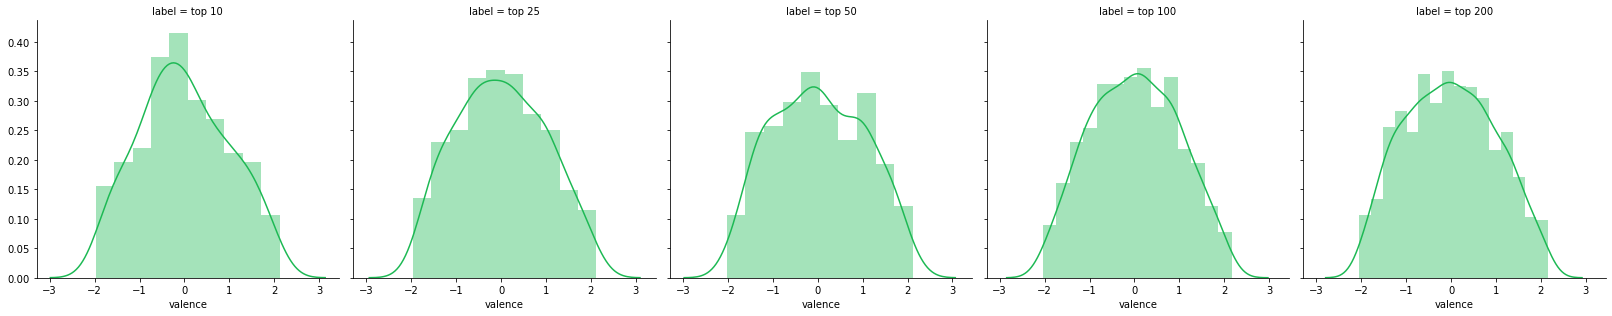

In [233]:
g = sns.FacetGrid(dist_plot_df_std, col="label", height=4.5, aspect=1, col_order=col_order, palette=palette)
g.map(sns.distplot, "valence")

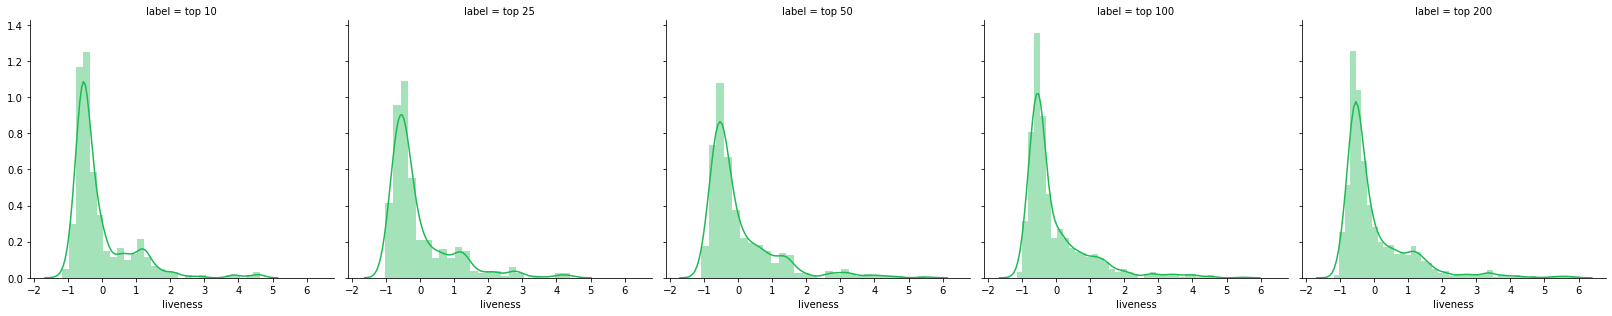

In [234]:
g = sns.FacetGrid(dist_plot_df_std, col="label", height=4.5, aspect=1, col_order=col_order, palette=palette)
g.map(sns.distplot, "liveness")

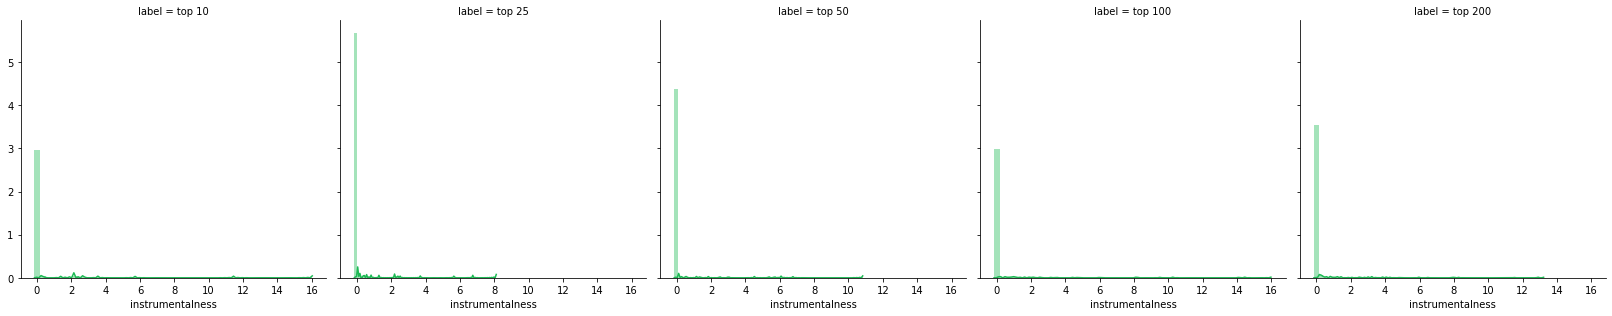

In [235]:
g = sns.FacetGrid(dist_plot_df_std, col="label", height=4.5, aspect=1, col_order=col_order, palette=palette)
g.map(sns.distplot, "instrumentalness")

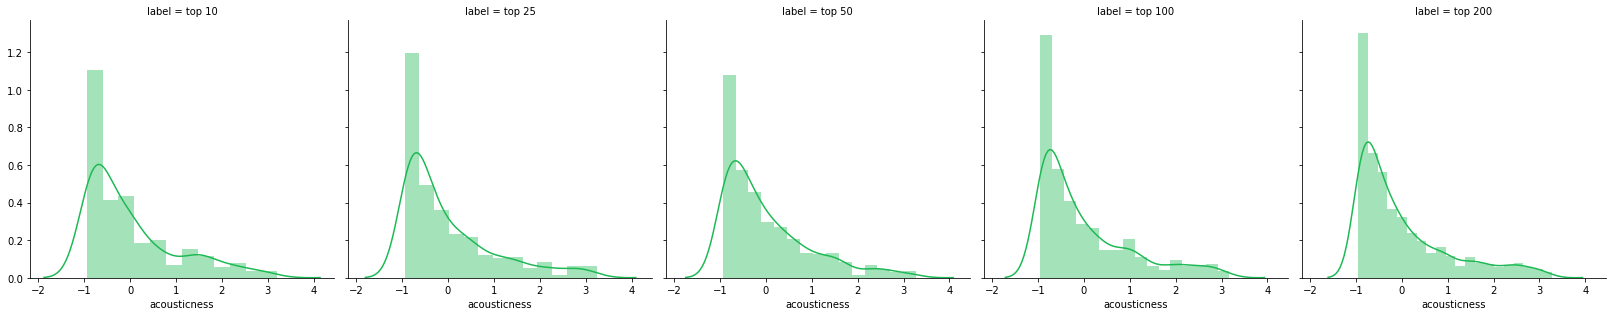

In [236]:
g = sns.FacetGrid(dist_plot_df_std, col="label", height=4.5, aspect=1, col_order=col_order, palette=palette)
g.map(sns.distplot, "acousticness")

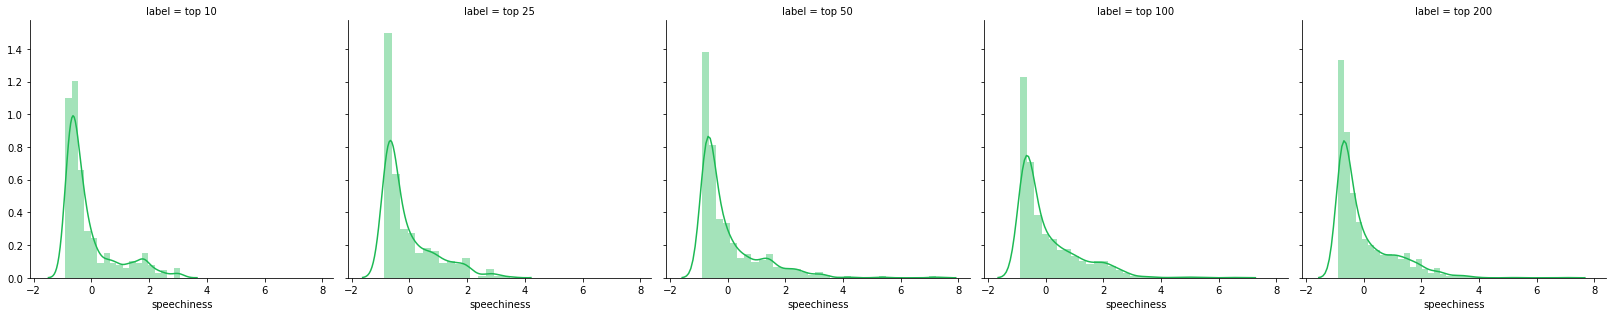

In [237]:
g = sns.FacetGrid(dist_plot_df_std, col="label", height=4.5, aspect=1, col_order=col_order, palette=palette)
g.map(sns.distplot, "speechiness")

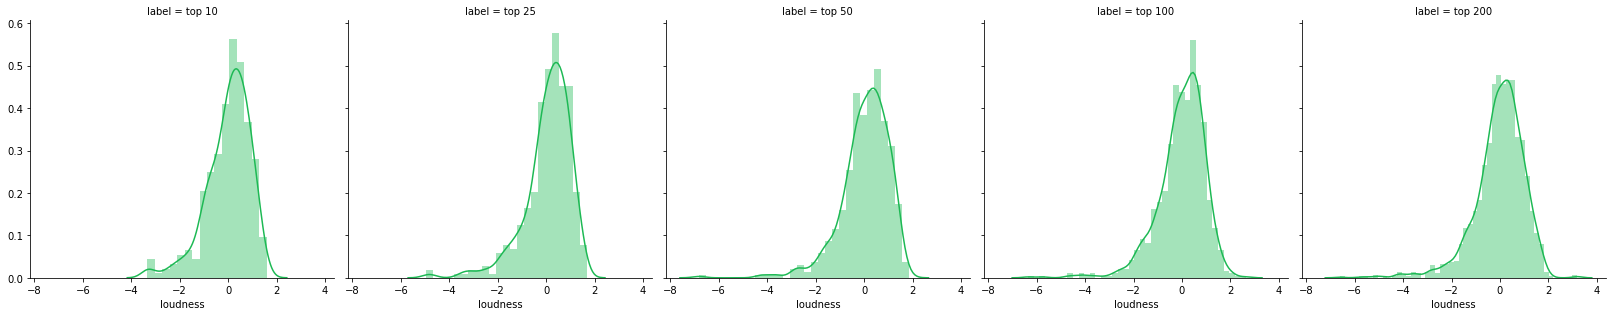

In [241]:
g = sns.FacetGrid(dist_plot_df_std, col="label", height=4.5, aspect=1, col_order=col_order, palette=palette)
g.map(sns.distplot, "loudness")

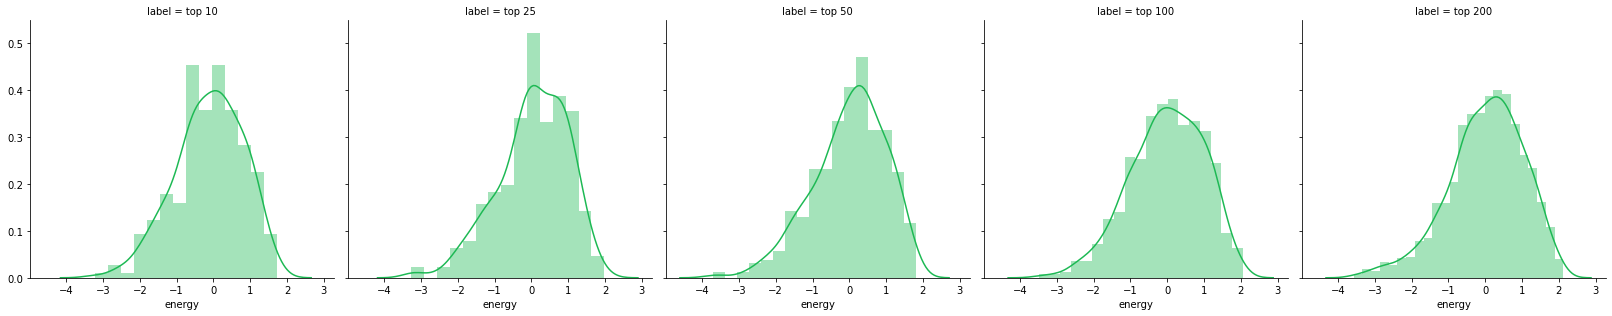

In [242]:
g = sns.FacetGrid(dist_plot_df_std, col="label", height=4.5, aspect=1, col_order=col_order, palette=palette)
g.map(sns.distplot, "energy")

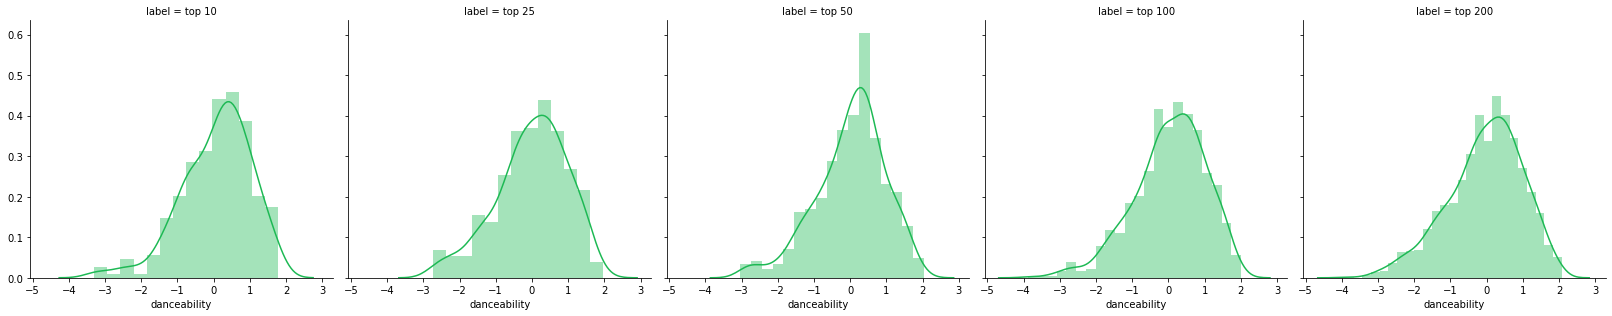

In [243]:
g = sns.FacetGrid(dist_plot_df_std, col="label", height=4.5, aspect=1, col_order=col_order, palette=palette)
g.map(sns.distplot, "danceability")

### Evaluacion del clustering<a class="anchor" id="eval_clustering"></a>

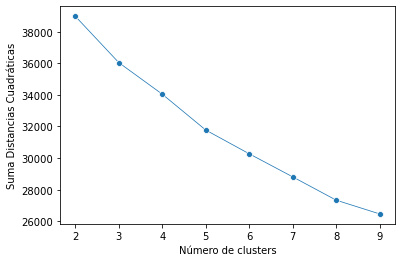

In [114]:
sq_distances=[]
k_values=range(2,10);

for k in k_values:
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(scaled_features)
    sq_distances.append(kmeans.inertia_)

sns.lineplot(x=k_values,y=sq_distances,marker='o',size=30,legend=False);
plt.ylabel('Suma Distancias Cuadráticas');plt.xlabel('Número de clusters');    

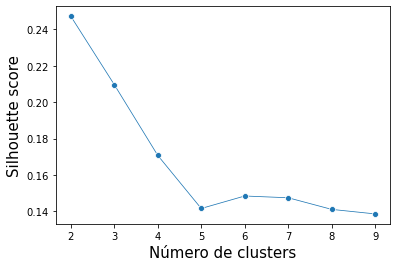

In [115]:
from sklearn.metrics import silhouette_score,silhouette_samples

sil=[]
k_values=range(2,10);

for k in k_values:
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(X_scaled)
    score=silhouette_score(X_scaled,kmeans.labels_)
    sil.append(score)

sns.lineplot(x=k_values,y=sil,marker='o',size=30,legend=False);
plt.ylabel('Silhouette score',fontsize=15);plt.xlabel('Número de clusters',fontsize=15);

For n_clusters = 2 The average silhouette_score is : 0.24674380157091327
For n_clusters = 3 The average silhouette_score is : 0.21725971841558428
For n_clusters = 4 The average silhouette_score is : 0.17132215938488124
For n_clusters = 5 The average silhouette_score is : 0.170207844840038
For n_clusters = 6 The average silhouette_score is : 0.14833242530521562
For n_clusters = 7 The average silhouette_score is : 0.14751324881635008
For n_clusters = 8 The average silhouette_score is : 0.1410181816042541
For n_clusters = 9 The average silhouette_score is : 0.13758118014629644


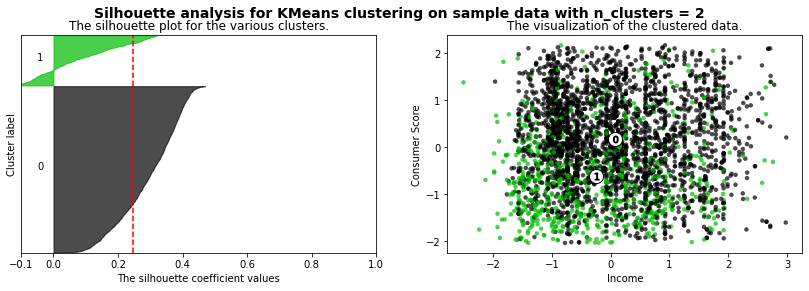

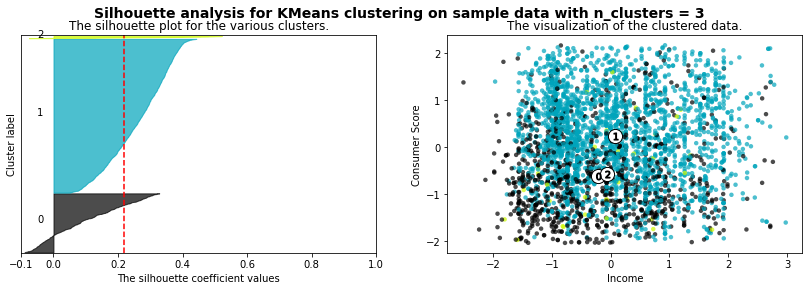

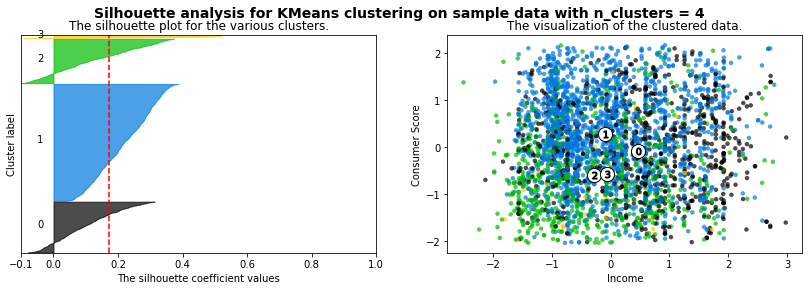

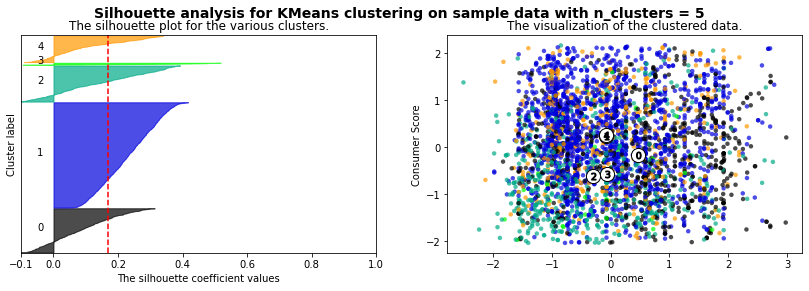

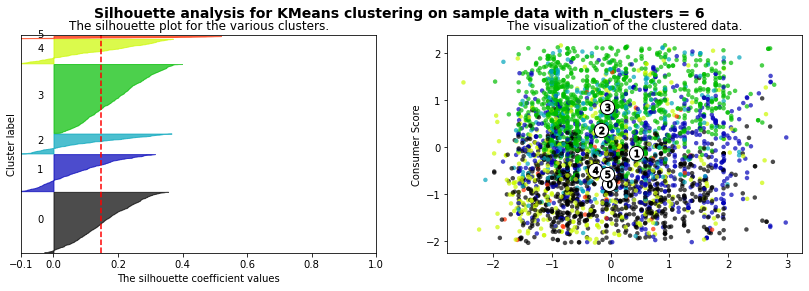

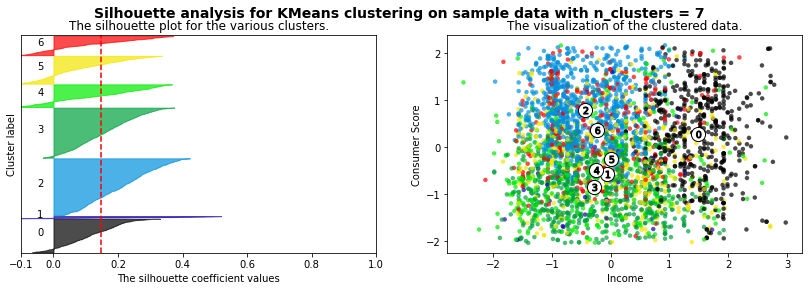

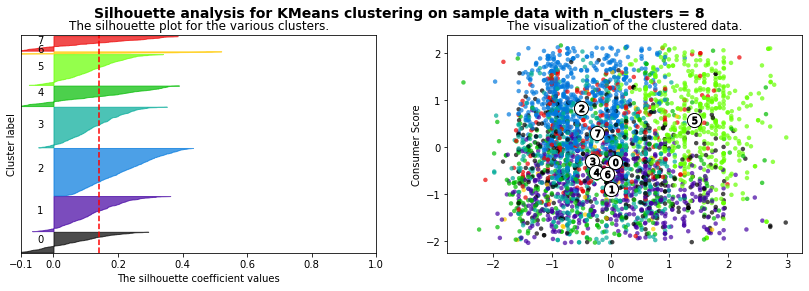

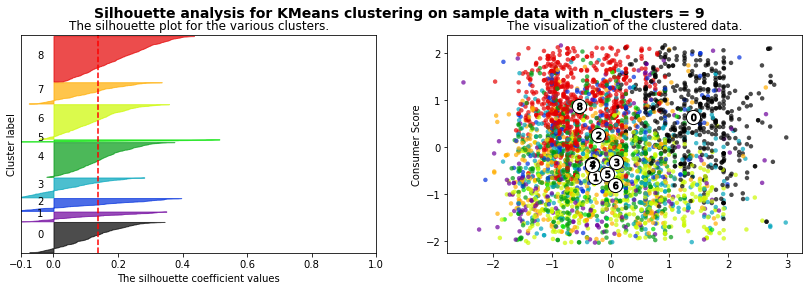

In [116]:
import matplotlib.cm as cm

for n_clusters in range(2,10):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(14, 4)
    
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_scaled) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_scaled)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_scaled[:, 0], X_scaled[:, 1], marker='.', s=80, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Income")
    ax2.set_ylabel("Consumer Score")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()


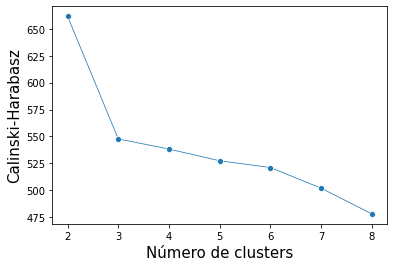

In [117]:
k_values=range(2,9);
ch_scores=[]

for k in k_values:
    
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(X_scaled)
    score=calinski_harabasz_score(X_scaled,kmeans.labels_)
    ch_scores.append(score)

sns.lineplot(x=k_values,y=ch_scores,marker='o',size=30,legend=False);
plt.ylabel('Calinski-Harabasz',fontsize=15);plt.xlabel('Número de clusters',fontsize=15);


### Entrenamiento del modelo<a class="anchor" id="clustering_entrenamiento"></a>

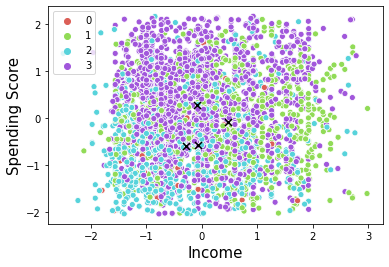

In [118]:
scaler=StandardScaler()

X_scaled=scaler.fit_transform(X);

kmeans=KMeans(n_clusters=4, n_init=10, random_state=0) # Numero de repeticiones=10
kmeans.fit(X_scaled)

labels = kmeans.labels_ # Etiquetas que indican a qué cluster pertenecen los datos
centroids = kmeans.cluster_centers_ # Coordenadas de los centroides

sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1],
                hue=labels,legend='full',
                palette=sns.color_palette("hls", 4));

plt.xlabel('Income',fontsize=15);plt.ylabel('Spending Score',fontsize=15);
plt.scatter(centroids[:, 0],centroids[:, 1],marker='x',s=50,color='k');


### PCA analisis

[9.99999523e-01 4.66772308e-07 6.86872691e-09 3.09136170e-09]


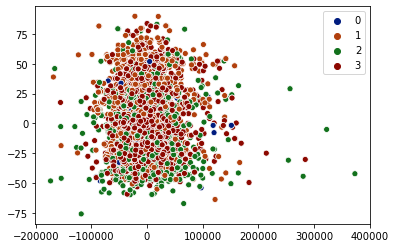

In [119]:
k=4;
km=KMeans(n_clusters=k, random_state=0)
km.fit(X_scaled)

pca=PCA(n_components=4)
pca_variables = pca.fit_transform(columnas)

sns.scatterplot(pca_variables[:, 0], pca_variables[:, 1], 
                hue=km.labels_, palette='dark');

print (pca.explained_variance_ratio_)

### Manifold

In [120]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=3, random_state=150).fit_transform(columnas)

# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300).fit_transform(data_subset)

<AxesSubplot:xlabel='manifold_x', ylabel='manifold_y'>

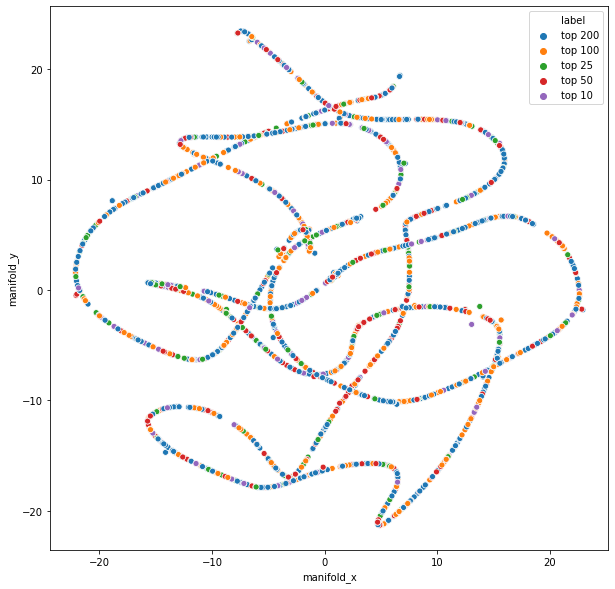

In [121]:
prueba_manifold = columnas.copy()
prueba_manifold["manifold_x"] = X_embedded[:,0]
prueba_manifold["manifold_y"] = X_embedded[:,1]
plt.figure(figsize=(10,10))
sns.scatterplot(data=prueba_manifold,
                x="manifold_x", y="manifold_y",
                hue=data_y)

# Iteracion sobre modelos de clasificacion <a class="anchor" id="clasificacion"></a>

### Feature Engineering

In [122]:
display(data_x.columns)
prueba = data_x[['streams', 'tempo', 'valence', 'liveness', 'instrumentalness',
       'acousticness', 'speechiness', 'loudness', 'energy', 'danceability',
       'time_signature_1', 'time_signature_3', 'time_signature_4',
       'time_signature_5']]

mejores_5 = data_x[['speechiness', 'danceability', 'energy', 'liveness',]]

Index(['streams', 'tempo', 'valence', 'liveness', 'instrumentalness',
       'acousticness', 'speechiness', 'loudness', 'energy', 'danceability',
       'time_signature_1', 'time_signature_3', 'time_signature_4',
       'time_signature_5'],
      dtype='object')

In [123]:



bestfeatures = SelectKBest(score_func=f_classif, k="all")
fit = bestfeatures.fit(mejores_5, data_y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(data_x.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns, dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
# print(featureScores.nlargest(10,'Score'))  #print 10 best features
featureScores.sort_values(by="Score", inplace=True, ascending=False)
featureScores

,Specs,Score
0,streams,2.224266
1,tempo,1.504756
2,valence,1.333740
3,liveness,1.278801
4,instrumentalness,NaN
5,acousticness,NaN
6,speechiness,NaN
7,loudness,NaN
8,energy,NaN
9,danceability,NaN


# Entrenado de modelos uno por uno

In [124]:
scores = []
modeloknn = KNeighborsClassifier()
nombre = 'KNeighborsClassifier'
params = {
    'n_neighbors':range(1,15)
}
grid = GridSearchCV(modeloknn, params, cv=3)
grid.fit(train_x, train_y)
modelo_params = grid.best_params_
modelo_score = grid.best_score_ 

scores.append('{} score: {}, best params: {}'.format(nombre, modelo_score, modelo_params))

In [125]:
modelo = LogisticRegression()
nombre = 'LogisticRegression'
params = {
    'C':[0.1,0.25,0.5,0.75,1],
    }
grid = GridSearchCV(modelo,params,cv=3)
grid.fit(train_x,train_y)
modelo_params = grid.best_params_
modelo_score = grid.best_score_ 

scores.append('{} score: {}, best params: {}'.format(nombre,modelo_score,modelo_params))
pp.pprint(scores)

["KNeighborsClassifier score: 0.4273598820058997, best params: {'n_neighbors': "
 '11}',
 "LogisticRegression score: 0.4815634218289085, best params: {'C': 0.75}"]


In [126]:
modelo = GaussianNB()
nombre = 'GaussianNB'
params = {}
grid = GridSearchCV(modeloknn,params,cv=3)
grid.fit(train_x,train_y)
modelo_params = grid.best_params_
modelo_score = grid.best_score_ 

scores.append('{} score: {}, best params: {}'.format(nombre,modelo_score,modelo_params))


In [127]:
modelo = SVC()
nombre = 'SVC'
params = {
    'C':[0.01, 0.1, 0.25, 0.5, 0.75,1],
    'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': range(2,5)
}
grid = GridSearchCV(modelo,params,cv=3)
grid.fit(train_x,train_y)
modelo_params = grid.best_params_
modelo_score = grid.best_score_ 

scores.append('{} score: {}, best params: {}'.format(nombre,modelo_score,modelo_params))


In [128]:
modelo = DecisionTreeClassifier()
nombre = 'DecisionTreeClassifier'
params = {
    'max_depth':range(3,11)
}
grid = GridSearchCV(modelo,params,cv=3)
grid.fit(train_x,train_y)
modelo_params = grid.best_params_
modelo_score = grid.best_score_ 

scores.append('{} score: {}, best params: {}'.format(nombre,modelo_score,modelo_params))

In [129]:
modelo = RandomForestClassifier()
nombre = 'RandomForestClassifier'
params = {
    'n_estimators':range(50,300,25)
}
grid = GridSearchCV(modelo,params,cv=3)
grid.fit(train_x,train_y)
modelo_params = grid.best_params_
modelo_score = grid.best_score_ 

scores.append('{} score: {}, best params: {}'.format(nombre,modelo_score,modelo_params))

In [130]:
modelo = LinearDiscriminantAnalysis()
nombre = 'LinearDiscriminantAnalysis'
params = {
    'solver' : ['svd', 'lsqr', 'eigen']
}
grid = GridSearchCV(modelo,params,cv=3)
grid.fit(train_x,train_y)
modelo_params = grid.best_params_
modelo_score = grid.best_score_ 

scores.append('{} score: {}, best params: {}'.format(nombre,modelo_score,modelo_params))

C:\Users\herna\miniconda3\envs\dhdsblend\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\herna\miniconda3\envs\dhdsblend\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\herna\miniconda3\envs\dhdsblend\lib\site-packages\sklearn\discriminant_analysis.py", line 468, in fit
    self._solve_eigen(X, y, shrinkage=self.shrinkage)
  File "C:\Users\herna\miniconda3\envs\dhdsblend\lib\site-packages\sklearn\discriminant_analysis.py", line 335, in _solve_eigen
    evals, evecs = linalg.eigh(Sb, Sw)
  File "C:\Users\herna\miniconda3\envs\dhdsblend\lib\site-packages\scipy\linalg\decomp.py", line 493, in eigh
    " computed." % (info-b1.shape[0]))
numpy.linalg.LinAlgError: the leading minor of order 14 o

# Pipelines <a class="anchor" id="pipelines"></a>

In [131]:
# # # Pipelines para cada modelo # # #
pipe_knn = Pipeline([('scl', StandardScaler()), 
                     ('clf', KNeighborsClassifier())])

pipe_lreg = Pipeline([('scl', StandardScaler()), 
                      ('clf', LogisticRegression())])

pipe_gauss = Pipeline([('scl', StandardScaler()), 
                       ('clf', GaussianNB())])

pipe_SVC = Pipeline([('scl', StandardScaler()), 
                     ('clf', SVC())])

pipe_dtree = Pipeline([('scl', StandardScaler()), 
                       ('clf', DecisionTreeClassifier())])

pipe_rforest = Pipeline([('scl', StandardScaler()), 
                         ('clf', RandomForestClassifier())])

pipe_ldisc = Pipeline([('scl', StandardScaler()), 
                       ('clf', LinearDiscriminantAnalysis())])


# # # Parámetros para cada modelo # # #

knn_params = {'clf__n_neighbors': [1,2,3,4]}

lreg_params = {'clf__penalty': ['l1', 'l2'],
                'clf__C': [1.0, 0.5, 0.1],
                'clf__solver': ['liblinear']}

gauss_params = {}

svc_params = {
    'clf__C':[0.01, 0.1, 0.25, 0.5, 0.75,1],
    'clf__kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'clf__degree': range(2,5)
}

dtree_params = {
    'clf__max_depth':range(3,11)
}

rforest_params = {
    'clf__n_estimators':range(50,300,25)
}

ldisc_params = {
    'clf__solver' : ['svd', 'lsqr', 'eigen']
}

# # # Armando los pares de pipeline y parametros
pipes = [pipe_knn, pipe_lreg, pipe_gauss, pipe_SVC, pipe_dtree, pipe_rforest, pipe_ldisc]
params = [knn_params, lreg_params, gauss_params, svc_params, dtree_params, rforest_params, ldisc_params]
pipe_params = zip(pipes, params)

In [132]:
folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
modelos = []
best_acc = 0.0
best_clf = 0
best_gs = ''

for pipe, params in pipe_params:
    X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, 
                                                        test_size=0.3, random_state=30, 
                                                        stratify=data_y)
    grid = GridSearchCV(pipe, params, 
                        cv=folds, n_jobs=-1, 
                        scoring="accuracy")
    
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    score = accuracy_score(grid.best_estimator_.predict(X_test), y_test)
    
    print (f"""\nmodelo: {str(pipe[1])},
            score: {score},
            modelo: {grid.best_estimator_},
            parametros: {grid.best_params_})"""
          )
    modelos.append(grid)
    
    if accuracy_score(y_test, y_pred) > best_acc:
        best_acc = accuracy_score(y_test, y_pred)
        mejor_modelo = grid
        best_clf = mejor_modelo.best_params_

print(f'\nEl mejor modelo fue:\n {mejor_modelo}\n Con los parametros\n {grid.best_params_}' )


modelo: KNeighborsClassifier(),
            score: 0.35363457760314343,
            modelo: Pipeline(steps=[('scl', StandardScaler()),
                ('clf', KNeighborsClassifier(n_neighbors=4))]),
            parametros: {'clf__n_neighbors': 4})

modelo: LogisticRegression(),
            score: 0.46070726915520627,
            modelo: Pipeline(steps=[('scl', StandardScaler()),
                ('clf', LogisticRegression(penalty='l1', solver='liblinear'))]),
            parametros: {'clf__C': 1.0, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'})

modelo: GaussianNB(),
            score: 0.10805500982318271,
            modelo: Pipeline(steps=[('scl', StandardScaler()), ('clf', GaussianNB())]),
            parametros: {})

modelo: SVC(),
            score: 0.47053045186640474,
            modelo: Pipeline(steps=[('scl', StandardScaler()),
                ('clf', SVC(C=0.5, degree=2, kernel='linear'))]),
            parametros: {'clf__C': 0.5, 'clf__degree': 2, 'clf__kernel': 'linear'

In [133]:
scores=[]
folds=StratifiedKFold(n_splits=5,shuffle=True, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,
                                                    random_state=30,
                                                    stratify=data_y)

dtree = DecisionTreeClassifier(random_state=0)
params = {
    'max_depth':range(2,11),
    "max_features":range(2,10),
    "ccp_alpha": [0.01, 0.1, 0.25, 0.5]
}

grid = GridSearchCV(dtree, params, cv=3)
grid.fit(train_x, train_y)
modelo_params = grid.best_params_
modelo_score = grid.best_score_ 

scores.append('{} score: {}, best params: {}'.format(nombre,modelo_score,modelo_params))

In [134]:
from sklearn.model_selection import cross_val_score

best_dtree = DecisionTreeClassifier(**modelo_params)
best_dtree.fit(X_train, y_train)

y_pred = best_dtree.predict(X_test)
best_dtree.feature_importances_

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [135]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
display(pd.DataFrame(confusion))
# confusion
display(pd.Series(y_pred).value_counts())

,0,1,2,3,4
0,0,0,21,0,54
1,0,0,171,0,42
2,0,0,325,0,26
3,0,0,35,0,55
4,0,0,69,0,50


top 200    621
top 50     227
dtype: int64

In [136]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']))


Accuracy: 0.44

Micro Precision: 0.44
Micro Recall: 0.44
Micro F1-score: 0.44

Macro Precision: 0.15
Macro Recall: 0.27
Macro F1-score: 0.19

Weighted Precision: 0.25
Weighted Recall: 0.44
Weighted F1-score: 0.32

Classification Report

              precision    recall  f1-score   support

     Class 1       0.00      0.00      0.00        75
     Class 2       0.00      0.00      0.00       213
     Class 3       0.52      0.93      0.67       351
     Class 4       0.00      0.00      0.00        90
     Class 5       0.22      0.42      0.29       119

    accuracy                           0.44       848
   macro avg       0.15      0.27      0.19       848
weighted avg       0.25      0.44      0.32       848



C:\Users\herna\miniconda3\envs\dhdsblend\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\herna\miniconda3\envs\dhdsblend\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### PCA extendido

In [137]:
sin_stream = data_x.drop(columns=["streams"])
scaler = StandardScaler()
sin_stream_scaled = scaler.fit_transform(sin_stream)
df_sin_stream = pd.DataFrame(sin_stream_scaled)
df_sin_stream.join(data_x["streams"])
# df_sin_stream

,0,1,2,3,4,5,6,7,8,9,10,11,12,streams
0,0.263119,0.553915,0.315968,-0.147649,-0.931920,1.989211,-0.645267,-1.213362,1.911025,-0.062036,-0.177876,0.229736,-0.126007,2.457010e+07
1,1.124320,1.936746,-0.388824,-0.147649,-0.136587,1.902866,-0.090202,-0.608386,0.829338,-0.062036,-0.177876,0.229736,-0.126007,1.319123e+07
2,-0.402316,1.354972,0.458426,-0.147649,-0.696783,0.728585,0.123190,-0.812102,1.903813,-0.062036,-0.177876,0.229736,-0.126007,9.777853e+06
3,0.094894,0.048220,0.300973,-0.147649,-0.025994,-0.519090,0.036449,-0.744197,0.822127,-0.062036,-0.177876,0.229736,-0.126007,2.445633e+07
4,-0.008363,1.260994,1.463130,-0.147649,0.050571,0.037831,0.062919,0.181787,1.024041,-0.062036,-0.177876,0.229736,-0.126007,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3386,1.456291,1.471327,-0.471300,-0.147649,-0.425830,1.013521,0.892869,1.046039,-0.490320,-0.062036,-0.177876,0.229736,-0.126007,0.000000e+00
3387,-0.899791,0.755298,-0.493793,-0.147649,0.811961,-0.818704,0.284456,-0.676291,0.403874,-0.062036,-0.177876,0.229736,-0.126007,1.705497e+09
3388,-1.132154,1.704036,-0.852938,-0.147649,-0.625748,1.410704,0.842779,-0.046622,1.492772,-0.062036,-0.177876,0.229736,-0.126007,1.464452e+08
3389,-0.469241,1.417625,-0.703732,-0.147649,-0.684022,-0.472464,-0.445721,-0.398496,0.800493,-0.062036,-0.177876,0.229736,-0.126007,1.835440e+08


In [138]:
from sklearn.decomposition import PCA
pca=PCA(n_components=4)
pca_variables = pca.fit_transform(sin_stream_scaled)
pca_streams = pd.DataFrame(pca_variables)
pca_streams["streams"] = data_x["streams"]

k=4;
km = KMeans(n_clusters=k, random_state=0)
km.fit(pca_streams)

KMeans(n_clusters=4, random_state=0)

[0.2083432  0.13839001 0.09703552 0.08406055]


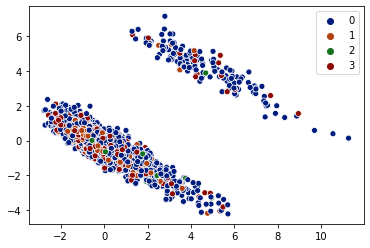

In [139]:
sns.scatterplot(pca_variables[:, 0], pca_variables[:, 1], 
                hue=km.labels_, palette='dark');

print (pca.explained_variance_ratio_)